In [188]:
import numpy as np
import pandas as pd
import sqlite3
import os

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

from gaussfit import *

## Functions for channel mapping

In [209]:
def readSqlitedb(database="/cvmfs/icarus.opensciencegrid.org/products/icarus/icarus_data/v09_62_00/icarus_data/database/ChannelMapICARUS.db", table="pmt_placements"):

    # Read sqlite query results into a pandas DataFrame
    con = sqlite3.connect(database)
    df = pd.read_sql_query("SELECT * from {}".format(table), con)
    con.close()

    return df

def channel_to_PMTid(channels):
    
    geo = readSqlitedb()
    if np.isscalar(channels):
        pmt_id = geo[geo.channel_id==channels].pmt_id.values[0]
        return pmt_id
    else:
        pmt_ids = [ geo[geo.channel_id==ch].pmt_id.values[0] for ch in channels ] 
        return pmt_ids
    
def PMTid_to_channel(pmt_ids):
    
    geo = readSqlitedb()
    if np.isscalar(pmt_ids):
        channel = geo[geo.pmt_id==pmt_ids].channel_id.values[0]
        return channel
    else:
        channels = [ geo[geo.pmt_id==pmt].channel_id.values[0] for pmt in pmt_ids ] 
        return channels
    
def getCryo(channel):
    board = geo[geo.channel_id==channel].digitizer_label.values[0]
    wall, pos, num = board.split("-")
    if wall[0] == "W":
        return 1
    elif wall[0] == "E":
        return 0
    
def readPlacements(file="/icarus/data/users/mvicenzi/pmt-calibration/input/pmt_positions.csv"):
    geo = pd.read_csv(file,sep=",")
    geo.drop(columns=["entry","subentry"],inplace=True)
    return geo

def getX(ch):
    geo = readPlacements()
    return geo["pmt_x"].iloc[ch]

def getY(ch):
    geo = readPlacements()
    return geo["pmt_y"].iloc[ch]

def getZ(ch):
    geo = readPlacements()
    return geo["pmt_z"].iloc[ch]

In [190]:
from scipy.optimize import curve_fit

def line(x, a, b ):
    return a*x+b

## Functions for data loading

In [191]:
# Get the timestamp
def getTimestamp(file):
    
    buff=file.split('_')
    timestamp = int(buff[-1].split('.')[0])
    
    return timestamp
    
# Get run number
def getRun(file):

    buff=file.split('_')
    run = int(buff[-2].lstrip("run"))

    return run

############################### DATA IMPORTER FUNCTIONS ###############################

# Load a single file
def getDataFrame(file, offchs, timeseries=True, run=True):
   
    df=pd.read_csv(file, sep=',')
    
    # remove list of PMTs that are off
    df= df[~df['pmt'].isin(offchs)]
    
    if timeseries:
        df["timestamp"] = getTimestamp(file)
        df['date'] = pd.to_datetime(df['timestamp'], unit='s')
        df.set_index("timestamp", inplace=True)
        
    if run:
        df["run"] = getRun(file)
    
    return df
    
def dataLoader( offchPMTs, sourcedir = "../calibrationdb/", interval=(1610067905, 1637788392)):
        
    print("Import data in folder{} for interval ({}:{})".format(sourcedir, interval[0], interval[1]))
    
    # Load the data from the fit database
    data = pd.concat([ getDataFrame(sourcedir+file, offchPMTs) for file in  os.listdir(sourcedir) if "backgroundphotons" in file ])
    # keep data only for the selected interval
    data = data.loc[(data.index>=interval[0]) & (data.index<interval[1])]  
    # Sort the indeces by time
    data = data.sort_index()
    
    return data

###############################

def fitGains(x):
    BINSIZE=0.005; RMIN=0.0; RMAX=1.0; p0=(0.4, 0.04);
    nbins=int((RMAX-RMIN)/BINSIZE)
    ys,edges = np.histogram(x,bins=nbins,range=(RMIN,RMAX))
    xs=np.array([edges[i]+0.5*(edges[i+1]-edges[i]) for i in range(len(ys))])

    param = [np.max(ys), p0[0], p0[1] ]
    bounds = np.array([(param[0]*0.5,param[0]*1.5),
              (param[1]*0.2,param[1]*1.3),
              (param[2]*0.1,param[2]*1.4)])
    
    param,pcov = curve_fit(gaus, xs, ys, p0=param, bounds=(bounds[:,0],bounds[:,1]) )
    eparam = np.diag(pcov)**0.5
    equal, eEqual = getEqualization( param[1], param[2], param[2], eparam[2] )
    
    return param[1], param[2], equal, eEqual # returns mean_q, sigma, equal, eEqual

# Getting data for plotting

In [192]:
# Define source parameters 
sdir   = "/icarus/data/users/mvicenzi/pmt-calibration/calibrationdb/"

# Import data between December 2022 and December 2023
trange = (1671100000, 1702598400)
# Import data between August 2021 and November 2021
# trange = (1627585983, 1636156757) # for pre-OB loss
# Import all available historical data
# trange = (1610067904,1702598400)

offPMTs = [1, 111, 143, 166, 192, 230, 238, 254, 222, 302, 309, 340, 353, 290 ]
offchs = PMTid_to_channel(offPMTs)

data = dataLoader( offchs, sdir, interval= trange)

Import data in folder/icarus/data/users/mvicenzi/pmt-calibration/calibrationdb/ for interval (1671100000:1702598400)


In [193]:
# drop unneeded colums
data.drop(columns=['chi2', 'fitstatus','ndf','amplitude','eamplitude','sigma','esigma','mu','emu'], inplace=True)
data.reset_index(inplace=True)
data["cryo"] = data.pmt.apply(lambda x: getCryo(x))

dplot = data.groupby(["timestamp","date","run"]).agg(list).reset_index()
dplot[["mean_fit_q","fit_sigma","equal","eEqual"]] = dplot.apply(lambda x: fitGains(x["q"]), axis=1, result_type='expand')

In [194]:
dplot.head()

,timestamp,date,run,pmt,nentries,q,eq,cryo,mean_fit_q,fit_sigma,equal,eEqual
0,1671126368,2022-12-15 17:46:08,9271,"[358, 115, 116, 117, 118, 119, 120, 121, 122, ...","[22720, 29749, 23671, 72473, 22673, 29289, 268...","[0.449218, 0.461456, 0.435913, 0.362441, 0.449...","[0.005667, 0.007322, 0.006393, 0.008007, 0.006...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.446760,0.007421,0.016611,0.000377
1,1672496767,2022-12-31 14:26:07,9342,"[246, 245, 244, 243, 242, 241, 240, 239, 238, ...","[92220, 278693, 83655, 96804, 92309, 91538, 86...","[0.438707, 0.46959, 0.446015, 0.448237, 0.4338...","[0.00264, 0.003264, 0.003052, 0.002321, 0.0028...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.446808,0.006358,0.014230,0.000234
2,1673715847,2023-01-14 17:04:07,9383,"[245, 244, 243, 242, 241, 240, 239, 238, 237, ...","[42207, 44316, 53545, 52415, 50858, 49982, 536...","[0.429429, 0.436388, 0.445641, 0.43705, 0.4421...","[0.005294, 0.004144, 0.00301, 0.003523, 0.0035...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.445850,0.006832,0.015323,0.000284
3,1673797513,2023-01-15 15:45:13,9384,"[245, 244, 243, 242, 241, 240, 239, 238, 237, ...","[230693, 80461, 93072, 86296, 87056, 86709, 91...","[0.472488, 0.44323, 0.446879, 0.433925, 0.4440...","[0.003488, 0.00292, 0.002241, 0.002791, 0.0025...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.445703,0.006762,0.015172,0.000239
4,1675449521,2023-02-03 18:38:41,9448,"[118, 119, 120, 121, 122, 123, 124, 125, 126, ...","[78527, 99893, 113958, 81088, 84058, 88560, 81...","[0.455765, 0.442795, 0.461116, 0.432932, 0.457...","[0.002843, 0.003404, 0.002841, 0.003072, 0.003...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.444021,0.006867,0.015466,0.000300


## Mean gain over time

Monthly loss: -0.6098209174600399%
Daily loss: -0.02032736391533466%


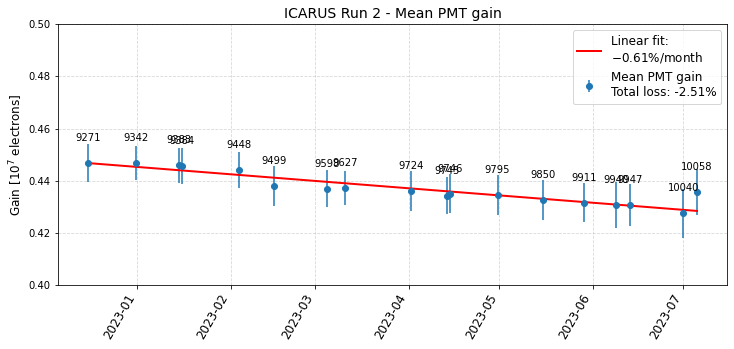

In [195]:
fig = plt.figure(figsize=(12, 4.8))

# total gain loss
qstart = dplot.loc[dplot['timestamp'].idxmin(), 'mean_fit_q']
qend = dplot.loc[dplot['timestamp'].idxmax(), 'mean_fit_q']
diff = qend-qstart
perc = diff/qstart*100

param,pcov = curve_fit(line, xdata=dplot.timestamp.to_numpy(), ydata=dplot.mean_fit_q.to_numpy(), sigma=dplot.fit_sigma.to_numpy())
ys = line(dplot.timestamp.to_numpy(),param[0],param[1])

month_in_s = 30*24*60*60
day_in_s = 24*60*60
month_loss = param[0]*month_in_s/qstart*100
day_loss = param[0]*day_in_s/qstart*100
print("Monthly loss: {:.4f}%".format(month_loss))
print("Daily loss: {:.4f}%".format(day_loss))

plt.plot( dplot.date.to_numpy(), ys, color="red", lw=2, label="Linear fit:\n$-${:.2f}%/month".format(-1*month_loss))
plt.errorbar( x=dplot.date, y=dplot.mean_fit_q, yerr=dplot.fit_sigma, fmt='o',label="Mean PMT gain\nTotal loss: {:.2f}%".format(perc))

for i,r in enumerate(dplot.run.to_numpy()):
    plt.annotate( str(r), xy=(dplot.date.to_numpy()[i],dplot.mean_fit_q.to_numpy()[i]),textcoords="offset points", xytext=(0,22), ha='center')

plt.ylim((0.4,0.5))
plt.ylabel("Gain [$10^7$ electrons]", fontsize=12)
plt.title("ICARUS Run 2 - Mean PMT gain", fontsize=14)
plt.grid(alpha=0.5, linestyle="dashed")
plt.setp(plt.gca().get_xticklabels(), rotation=60, ha="right", fontsize=12)
plt.legend(fontsize=12)

plt.savefig("figs/ICARUS-Run2_Mean_PMT_gain.png",dpi=600)
plt.show()

## Equalization over time

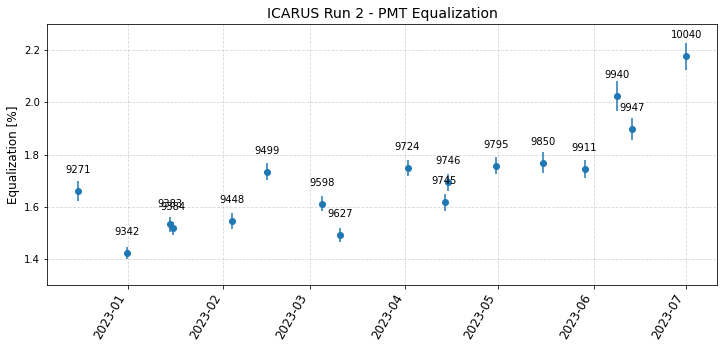

In [136]:
fig = plt.figure(figsize=(12, 4.8))

plt.errorbar( x=dplot.date, y=dplot.equal*100, yerr=dplot.eEqual*100, fmt='o')
for i,r in enumerate(dplot.run.to_numpy()):
    plt.annotate( str(r), xy=(dplot.date.to_numpy()[i],dplot.equal.to_numpy()[i]*100),textcoords="offset points", xytext=(0,18), ha='center')

plt.ylim((1.3,2.3))
plt.ylabel("Equalization [%]", fontsize=12)
plt.title("ICARUS Run 2 - PMT Equalization", fontsize=14)
plt.grid(alpha=0.5, linestyle="dashed")
plt.setp(plt.gca().get_xticklabels(), rotation=60, ha="right", fontsize=12)
#plt.legend(fontsize=12)

plt.savefig("figs/ICARUS-Run2_PMT_equalization.png",dpi=600)
plt.show()

## Single PMTs gain variation

In [137]:
dpmt = data.groupby(["pmt","cryo"]).agg(list).reset_index()
dpmt.head()

,pmt,cryo,timestamp,nentries,q,eq,date,run
0,0,0,"[1671126368, 1672496767, 1673715847, 167379751...","[19380, 144050, 41869, 97732, 80826, 34606, 68...","[0.426814, 0.43663, 0.431459, 0.441006, 0.4250...","[0.00622, 0.002914, 0.00362, 0.002725, 0.00294...","[2022-12-15 17:46:08, 2022-12-31 14:26:07, 202...","[9271, 9342, 9383, 9384, 9448, 9499, 9598, 962..."
1,1,0,"[1671126368, 1672496767, 1673715847, 167379751...","[23223, 73203, 41048, 69890, 72613, 32529, 760...","[0.462151, 0.446294, 0.44405, 0.437599, 0.4425...","[0.005272, 0.003111, 0.004463, 0.003461, 0.003...","[2022-12-15 17:46:08, 2022-12-31 14:26:07, 202...","[9271, 9342, 9383, 9384, 9448, 9499, 9598, 962..."
2,2,0,"[1671126368, 1672496767, 1673715847, 167379751...","[20491, 79100, 44455, 79181, 74359, 30558, 698...","[0.457998, 0.451296, 0.443223, 0.441667, 0.438...","[0.00508, 0.00337, 0.0045, 0.003457, 0.00351, ...","[2022-12-15 17:46:08, 2022-12-31 14:26:07, 202...","[9271, 9342, 9383, 9384, 9448, 9499, 9598, 962..."
3,3,0,"[1671126368, 1672496767, 1673715847, 167379751...","[20719, 77242, 42144, 76508, 81063, 29996, 738...","[0.44146, 0.437929, 0.4308, 0.437279, 0.43815,...","[0.005096, 0.003108, 0.004296, 0.003074, 0.002...","[2022-12-15 17:46:08, 2022-12-31 14:26:07, 202...","[9271, 9342, 9383, 9384, 9448, 9499, 9598, 962..."
4,4,0,"[1671126368, 1672496767, 1673715847, 167379751...","[18376, 74969, 41005, 72954, 72266, 29651, 696...","[0.445157, 0.4445, 0.437487, 0.445179, 0.44742...","[0.007321, 0.003599, 0.00494, 0.003417, 0.0033...","[2022-12-15 17:46:08, 2022-12-31 14:26:07, 202...","[9271, 9342, 9383, 9384, 9448, 9499, 9598, 962..."


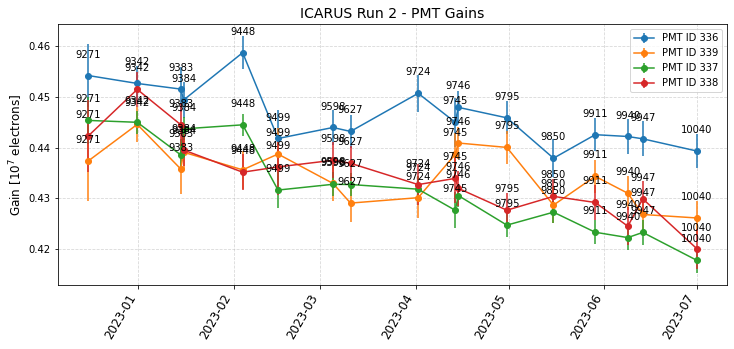

In [187]:
# select channels
channels = [0, 149, 185]

fig = plt.figure(figsize=(12, 4.8))
for ch in range(20,25): #in channels:
    
    if ch in offchs:
        continue
    _sel = dpmt.pmt == ch
    
    xs=dpmt[_sel].date.to_numpy()[0]
    ys=dpmt[_sel].q.to_numpy()[0]
    err=dpmt[_sel]['eq'].to_numpy()[0]
        
    plt.errorbar( x=xs, y=ys, yerr=err, fmt='o-', label='PMT ID {}'.format(channel_to_PMTid(ch)))
    for i,r in enumerate(dpmt[_sel].run.to_numpy()[0]):
        plt.annotate( str(r), xy=(xs[i],ys[i]),textcoords="offset points", xytext=(0,18), ha='center')

plt.ylabel("Gain [$10^7$ electrons]", fontsize=12)
plt.title("ICARUS Run 2 - PMT Gains", fontsize=14)
plt.grid(alpha=0.5, linestyle="dashed")
plt.setp(plt.gca().get_xticklabels(), rotation=60, ha="right", fontsize=12)
plt.legend()

#plt.savefig("figs/ICARUS-Run2_PMT_equalization.png",dpi=600)
plt.show()

## Gain by y quota

In [221]:
dpmt["y"] = dpmt.pmt.apply(lambda x: getY(x))
dyquota = dpmt.explode(["timestamp", "q","date","run"]).reset_index()
dyquota.drop(columns=["index","nentries","eq"],inplace=True)

,pmt,cryo,timestamp,q,date,run,y
0,0,0,1671126368,0.426814,2022-12-15 17:46:08,9271,-76.25
1,0,0,1672496767,0.43663,2022-12-31 14:26:07,9342,-76.25
2,0,0,1673715847,0.431459,2023-01-14 17:04:07,9383,-76.25
3,0,0,1673797513,0.441006,2023-01-15 15:45:13,9384,-76.25
4,0,0,1675449521,0.425014,2023-02-03 18:38:41,9448,-76.25


In [234]:
dy = dyquota.groupby(["timestamp","date","run","y"]).agg(list)
dy[["mean_fit_q","fit_sigma","equal","eEqual"]] = dy.apply(lambda x: fitGains(x["q"]), axis=1, result_type='expand')
dy.reset_index(inplace=True)
dy.drop(columns=["pmt","cryo","q","equal","eEqual"],inplace=True)
dy = dy.groupby(["y"]).agg(list).reset_index()
dy.head()

,y,timestamp,date,run,mean_fit_q,fit_sigma
0,-129.05,"[1671126368, 1672496767, 1673715847, 167379751...","[2022-12-15 17:46:08, 2022-12-31 14:26:07, 202...","[9271, 9342, 9383, 9384, 9448, 9499, 9598, 962...","[0.44514337430787426, 0.4471447249034276, 0.44...","[0.00822741625739344, 0.006630349070761678, 0...."
1,-76.25,"[1671126368, 1672496767, 1673715847, 167379751...","[2022-12-15 17:46:08, 2022-12-31 14:26:07, 202...","[9271, 9342, 9383, 9384, 9448, 9499, 9598, 962...","[0.4478999947681457, 0.44715986678552316, 0.44...","[0.0061131667662296645, 0.007054047757572943, ..."
2,-23.45,"[1671126368, 1672496767, 1673715847, 167379751...","[2022-12-15 17:46:08, 2022-12-31 14:26:07, 202...","[9271, 9342, 9383, 9384, 9448, 9499, 9598, 962...","[0.4481392908382345, 0.4475193366691762, 0.445...","[0.008400529151096731, 0.006717408273351623, 0..."
3,29.35,"[1671126368, 1672496767, 1673715847, 167379751...","[2022-12-15 17:46:08, 2022-12-31 14:26:07, 202...","[9271, 9342, 9383, 9384, 9448, 9499, 9598, 962...","[0.44572171864905585, 0.4464896319109015, 0.44...","[0.007454561184213674, 0.005846316597019467, 0..."
4,82.15,"[1671126368, 1672496767, 1673715847, 167379751...","[2022-12-15 17:46:08, 2022-12-31 14:26:07, 202...","[9271, 9342, 9383, 9384, 9448, 9499, 9598, 962...","[0.44702846838627536, 0.44550412841657455, 0.4...","[0.006095008295079878, 0.005003095977931849, 0..."


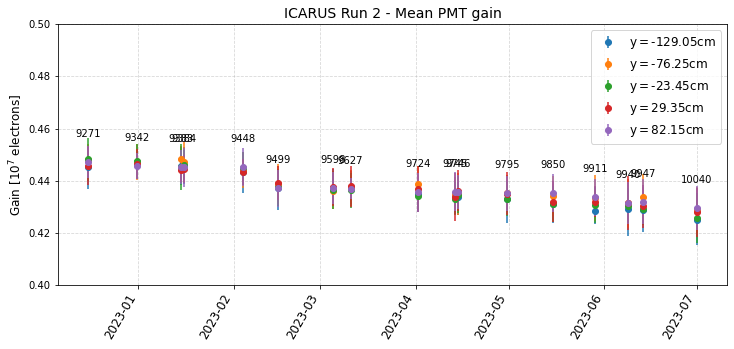

In [238]:
fig = plt.figure(figsize=(12, 4.8))

for quota in (-129.05,-76.25,-23.45,29.35,82.15):
    
    _sel = dy.y == quota
    xs=dy[_sel].date.to_numpy()[0]
    ys=dy[_sel].mean_fit_q.to_numpy()[0]
    err=dy[_sel].fit_sigma.to_numpy()[0]
    plt.errorbar( x=xs, y=ys, yerr=err, fmt='o',label="y$=${}cm".format(quota))

for i,r in enumerate(dy[_sel].run.to_numpy()[0]):
    plt.annotate( str(r), xy=(xs[i],ys[i]),textcoords="offset points", xytext=(0,25), ha='center')

plt.ylim((0.4,0.5))
plt.ylabel("Gain [$10^7$ electrons]", fontsize=12)
plt.title("ICARUS Run 2 - Mean PMT gain", fontsize=14)
plt.grid(alpha=0.5, linestyle="dashed")
plt.setp(plt.gca().get_xticklabels(), rotation=60, ha="right", fontsize=12)
plt.legend(fontsize=12)

plt.show()

## Gain by cryostat

In [215]:
# WEST
dw = data[data.cryo==1].groupby(["timestamp","date","run"]).agg(list).reset_index()
dw[["mean_fit_q","fit_sigma","equal","eEqual"]] = dw.apply(lambda x: fitGains(x["q"]), axis=1, result_type='expand')
# EAST
de = data[data.cryo==0].groupby(["timestamp","date","run"]).agg(list).reset_index()
de[["mean_fit_q","fit_sigma","equal","eEqual"]] = de.apply(lambda x: fitGains(x["q"]), axis=1, result_type='expand')

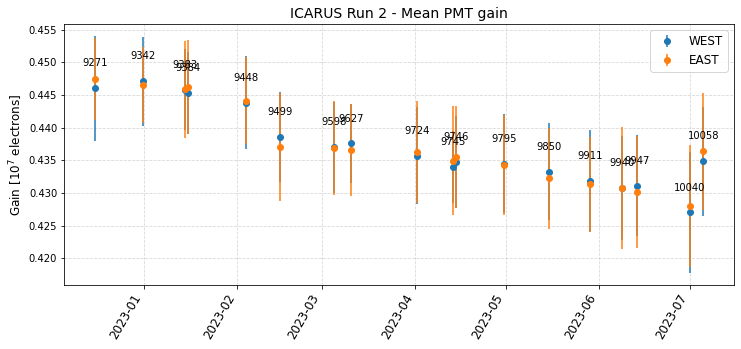

In [217]:
fig = plt.figure(figsize=(12, 4.8))

plt.errorbar( x=dw.date, y=dw.mean_fit_q, yerr=dw.fit_sigma, fmt='o',label="WEST")
plt.errorbar( x=de.date, y=de.mean_fit_q, yerr=de.fit_sigma, fmt='o',label="EAST")

for i,r in enumerate(dw.run.to_numpy()):
    plt.annotate( str(r), xy=(dw.date.to_numpy()[i],dw.mean_fit_q.to_numpy()[i]),textcoords="offset points", xytext=(0,22), ha='center')

#plt.ylim((0.4,0.5))
plt.ylabel("Gain [$10^7$ electrons]", fontsize=12)
plt.title("ICARUS Run 2 - Mean PMT gain", fontsize=14)
plt.grid(alpha=0.5, linestyle="dashed")
plt.setp(plt.gca().get_xticklabels(), rotation=60, ha="right", fontsize=12)
plt.legend(fontsize=12)

plt.show()